# Import Libraries & Set up the Environment

The below code sets up an initial calibration process for UMAP (Uniform Manifold Approximation and Projection) combined with HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) on textual data. It aims to determine suitable model parameters, which will subsequently be applied to a Large Language Model to generate coherent topics. The script imports various libraries, including numpy, sklearn, umap, hdbscan, SentenceTransformer, and others for text processing, data visualization, and natural language processing tasks. It also configures the visualization settings, downloads necessary NLTK resources, and specifies a project output directory path (rt). This notebook acts as an essential step in preparing the data for topic modeling by fine-tuning dimensionality reduction and clustering parameters.

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import hdbscan
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import re
from itertools import compress

from spellchecker import SpellChecker
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

%matplotlib inline
sns.set(style = 'white', context = 'poster', rc = {'figure.figsize':(14,10)})

#your desired Esri file geodatabase name that contains the project geographic feature layers and data tables
fgdbname = 'GeospatialTweetAnalysis.gdb'
#reference: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
state_shp = r'path/to/your/census/states/boundaries/shapefile'
# the path to your local directory containing all project files
rt = r'path/to/your/project/output/directory'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\babakr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\babakr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Write Functions for Document Cleaning 
The preprocess_text function is designed to prepare a given text document for analysis by conducting several text preprocessing tasks. It begins by tokenizing the text to isolate alphabetic words, eliminating numbers and special characters. Subsequently, it converts all tokens to lowercase and lemmatizes verbs to ensure text consistency. The result is a cleaned and standardized text document, free from non-alphabetic characters and irrelevant words, ready for use in topic modeling with TF-IDF at the final step.

In [96]:
def preprocess_text(text):
    
    """
    This function performs several text preprocessing steps on input text to prepare it for analysis

    INPUTS:
    text: The text document to preprocess

    OUTPUTS: 
    the converted token 
    """
    
    # 1. Tokenise to alphabetic tokens. This removes any number or etc. 
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') for t in tokens]

    # 3. Remove stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['cannot', 'could', 'done', 'let', 'may',  'might',  'must', 'need', 'ought',
                       'shall', 'would']+['thank','also','nan','na','us','anything','regard',
                                                'want','copy','review','please','know','original','think',
                                                'really','weekend','good','love','fun','go','come','get','hope',
                                                'great','click','special','question','document','doc'])
    tokens = [t for t in tokens if t not in stop_words]

    #return the corrected document
    return ' '.join(tokens)

# Step 1: Data Cleaning and Preprocessing 
The provided code segment pertains to the data preparation process to enhance the topic modeling performance and obtain more relevant embeddings. It initiates by creating a new column in the DataFrame named doubleclean_tweets, where each document is subjected to further cleaning and preprocessing using the preprocess_text function. Following this, lines with empty or uninformative tweets are removed from the DataFrame, ensuring that only meaningful data is retained. The resulting text documents are collected into a list for subsequent processing. Furthermore, the code establishes various conditions to filter the data based on specific criteria, such as sentiment and presidential association. Ultimately, these preparations aim to optimize the quality of text data for use in the topic generating model, improving its ability to extract meaningful topics. 

In [103]:
#now clean the data to improve the performance of BERTopic and get more relevant embeddings 
COVID_df['doubleclean_tweets'] = [preprocess_text(doc) for doc in COVID_df.clean_tweets]
#make sure getting rid of those lines with empty useless tweets after post cleaning
COVID_df = COVID_df[COVID_df.doubleclean_tweets! = '']
#convert the final documents to a list
data = list(COVID_df.doubleclean_tweets)

#create some conditions to filter based on specific targets 
cond_BidenPos = (COVID_df.President=='Biden') & (COVID_df.compound_polarity >= 0.05)
cond_BidenNeg = (COVID_df.President=='Biden') & (COVID_df.compound_polarity <= -0.05)
cond_TrumpPos = (COVID_df.President=='Trump') & (COVID_df.compound_polarity >= 0.05)
cond_TrumpNeg = (COVID_df.President=='Trump') & (COVID_df.compound_polarity <= -0.05)

#decided to do all Neg and Pos together to make it easier. 
cond_Neg = COVID_df.compound_polarity <= -0.05
cond_Pos = COVID_df.compound_polarity <= -0.05

COVID_df.head(1)

,user,date,content,user_location,searched_location,clean_tweets,compound_polarity,President,doubleclean_tweets
0,"{'username': 'Rachael_wv', 'displayname': 'Rac...",2021-05-06 23:18:26+00:00,Why does he still do daily covid announcements...,West Virginia,WV,Why does he still do daily covid announcements...,-0.5514,Biden,still daily covid announcements whatever wv st...


# Step 2: Document Embedding
The provided code segment involves transforming the input documents into 512-dimensional vectors. It begins by specifying the choice of a specific Large Language Model (LLM) available from HuggingFace's model hub. The selected model, 'paraphrase-xlm-r-multilingual-v1,' is identified as the optimal candidate for this task based on its performance, particularly in generating coherent topics. The code proceeds to initialize this model for text embedding. The data variable, which represents the text documents obtained from the previous data preparation steps, is encoded into 512-dimensional vectors using the selected LLM. This vectorization process is vital for topic modeling and further analysis of the text data. The code is timed using the %%time magic command to monitor the execution time.

In [111]:
%%time
model = SentenceTransformer('paraphrase-xlm-r-multilingual-v1')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/38159 [00:00<?, ?it/s]

Wall time: 5h 53min 38s


# Step 2: Save the Embeddings on Local Hard Drive
This code segment is responsible for saving the computed embeddings locally as a NumPy array. It begins by opening a file with the specified path (denoted by 'rt') where the embeddings will be saved. The np.save function is used to store the 'embeddings' data as a NumPy array in the opened file. This local storage of embeddings allows for easy access and retrieval when needed for future analysis. Additionally, the code provides a commented-out alternative section, which demonstrates how to load the saved embeddings from the local drive using np.load. This feature allows the embeddings to be easily reused in other tasks or analyses. 

In [112]:
#save the embedding locally as a numpy array
with open(rt + '\\COVID_embed_XLM.npy', 'wb') as f:
    np.save(f, embeddings)
#cab use the below code to loads the embeddings from local drive when needed
#with open(rt + '\\COVID_embed_XLM.npy', 'rb') as f:
#    embeddings = np.load(f)

# Step 3: Dimensionality Reduction of LLM Embeddings ¶
In this code snippet, dimensionality reduction is applied to the Large Language Model (LLM) embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is used to reduce the high-dimensional LLM embeddings into a lower-dimensional space, making it computationally more manageable and suitable for visualization. It focuses on specific documents based on the 'cond_Pos' condition, which pertains to positive tweets. The UMAP parameters, such as the number of neighbors, components, initialization method, minimum distance, and the distance metric used (cosine), are configured to achieve this dimensionality reduction. Additionally, a separate UMAP transformation is conducted for plotting purposes, resulting in a two-dimensional representation of the embeddings. The '%%time' is used to measure the execution time of this operation.

In [184]:
%%time
#reduce dims of the LLM embeddins using UMAP
cond = cond_Pos
dim_reduction_model = umap.UMAP(n_neighbors = 15, 
                            n_components = 5,
                            init = 'random',
                            min_dist = 0.1,
                            metric = 'cosine' 
umap_embeddings = dim_reduction_model.fit_transform(embeddings[cond])
#this is a 2d version which is only used for visualization   
umap_data = umap.UMAP(n_neighbors = 15, 
                      n_components = 2, 
                      min_dist = 0,
                      init = 'random', 
                      metric = 'cosine').fit_transform(embeddings[cond])

Wall time: 5min 49s


# Step 4: Cluserting of LLM Embeddings ¶
In this code, HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is applied to the 5-dimensional UMAP embeddings. By setting a small 'min_cluster_size,' the code reduces the presence of noisy data points and encourages more data points to be assigned to clusters. The default distance metric used is Euclidean due to the low dimensionality of the data. The 'cluster_selection_method' is set to 'eom,' which allows the algorithm to select clusters based on the Excess of Mass (EOM). The code then computes and returns the maximum label or cluster number generated by HDBSCAN, effectively indicating the number of clusters found during the clustering process. The '%%time' is used to measure the execution time of this operation.

In [194]:
%%time
#now apply hdbscan to cluster the 5-dim embeddings 
cluster_model = hdbscan.HDBSCAN(min_cluster_size = 1900, metric = 'euclidean', 
                          cluster_selection_method = 'eom')
cluster = cluster_model.fit(umap_embeddings)
#check the number of generated clusters
cluster.labels_.max()

Wall time: 2min 55s


15

# Step 5: Visualize Clusters ¶
In this code snippet, the 5-dimensional labeled clustering results are visualized in a 2-dimensional space using UMAP dimensionality reduction. A DataFrame is created to hold the 2-dimensional data for visualization. Outliers, indicated by labels equal to -1, are separated from clustered data points. The clusters are visualized in a scatter plot, with outliers shown in gray and clustered data points color-coded according to their labels, enhancing the visualization of the clustering results. The resulting plot provides an overview of the clustered data points and their distribution in the 2-dimensional space.

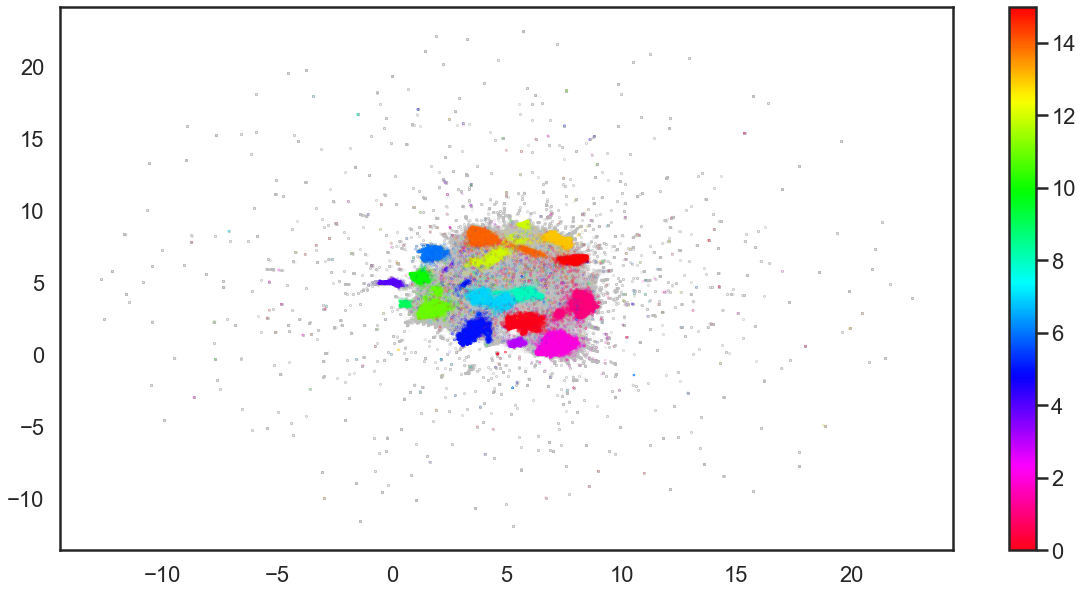

In [195]:
#create a df from 2d data for visualization
result = pd.DataFrame(umap_data, columns = ['x', 'y'])
result['labels'] = cluster.labels_
#seperate outliers which have label = -1
outliers = result.loc[result.labels == -1, :]
#seperate clustered data points
clustered = result.loc[result.labels != -1, :]
#visualize clusters
fig, ax = plt.subplots(figsize = (20, 10))
_ = plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s = 0.02)
_ = plt.scatter(clustered.x, clustered.y, c=clustered.labels,
                s = 0.02, cmap = 'hsv_r')
_ = plt.colorbar()

# Step 6: run BERTopic on LLM Embeddings
This code segment creates a BERTopic topic model using custom embedded vectors obtained from a previously trained model. The topic model is constructed with various parameters for UMAP and HDBSCAN models. It then processes the data to generate topics using the BERTopic model, saving the trained model to the local hard drive for future use and retrieving the frequency counts of popular topics. It also performs further topic reduction to merge similar topics using a similarity threshold of 0.9. Finally, the code aggregates topics and calculates the most frequent topic per president per location and prints the top 15 topics with their associated terms.

In [200]:
%%time
#Create topic model and use the custom embeded vectors from previously trained model
topic_model = BERTopic(verbose = True, 
                 umap_model = dim_reduction_model, 
                 hdbscan_model = cluster_model)
#prepare data 
data = np.array(list(compress(list(COVID_df.doubleclean_tweets), cond)))
# generate topics using bertopic

topics = topic_model.fit_transform(data, embeddings)

# save this model on local hard drive 
topic_model.save("XLM_BERTopic_Model")
# use this to load the saved model when needed later 
# Neg_model = BERTopic.load("XLM_BERTopic_Model")

#get counts of popular models
topic_model.get_topic_freq().head()

# Further reduce topics. auto ensures reduces those with similarity above 0.9 threshold
topics,_ = topic_model.reduce_topics(docs = data, 
                                       topics = topics[0],
                                       nr_topics = 'auto')

#now aggregate topics to get counts and most frequent topic per president per 
topics_df = COVID_df[COVID_df.Topics!=-1].groupby(['searched_location','President'],
                                                  as_index=False).agg({'Topics':lambda x:x.value_counts().index[0]})
#print and review the top 15 topics
for t in topics_df.Topics.value_counts(dropna = False).index:
    print('Topic:%s'%t)
    topic_model.get_topics()[t][:15]

Topic:4


[('vaccine', 0.10753609133080763),
 ('vaccines', 0.04342359812558817),
 ('vaccinate', 0.0322370174764869),
 ('vaccination', 0.02775064455680641),
 ('dose', 0.025275573437109608),
 ('first', 0.018503665700956278),
 ('today', 0.01748967072886061),
 ('shoot', 0.016990495674463924),
 ('people', 0.01689710873787032),
 ('receive', 0.016700124343449398),
 ('amp', 0.014569830446162524),
 ('pfizer', 0.013566641623230746),
 ('take', 0.013211215303048116),
 ('second', 0.013150847780892077),
 ('make', 0.012199337099440752)]

Topic:1


[('test', 0.17864301689704193),
 ('positive', 0.07955115327684265),
 ('quarantine', 0.045537340566767524),
 ('negative', 0.027033804540188326),
 ('free', 0.023267995479958947),
 ('result', 0.023117129146474687),
 ('days', 0.018562035282807175),
 ('today', 0.018522682713738463),
 ('symptoms', 0.018406902847922797),
 ('take', 0.01629142828182495),
 ('week', 0.015540978350307839),
 ('work', 0.01530845508733933),
 ('back', 0.015094947122027719),
 ('like', 0.014133554840616677),
 ('day', 0.01373474750456066)]

Topic:0


[('mask', 0.1740056310266838),
 ('wear', 0.11694377854638774),
 ('distance', 0.032733876041202876),
 ('people', 0.026769328137660163),
 ('social', 0.02331655297800499),
 ('face', 0.019263580432573882),
 ('still', 0.017347624478038007),
 ('hand', 0.017285278608916297),
 ('like', 0.01705707588643548),
 ('spread', 0.016172095169849823),
 ('protect', 0.015434479261750445),
 ('safe', 0.01492221918093039),
 ('wash', 0.01479397812228775),
 ('keep', 0.01420264782374628),
 ('amp', 0.01404842874683903)]

Topic:6


[('game', 0.08238452795650986),
 ('season', 0.07247698531883497),
 ('team', 0.06760610230285681),
 ('play', 0.05746685440834717),
 ('football', 0.03665416618163586),
 ('win', 0.03333908161380758),
 ('players', 0.032122539544075714),
 ('year', 0.028748706448409087),
 ('coach', 0.028334675554306975),
 ('due', 0.027231522350741066),
 ('cancel', 0.021911445892603073),
 ('fan', 0.018041954838515697),
 ('last', 0.01678019584721965),
 ('championship', 0.016421628482657182),
 ('league', 0.016106542519946893)]

Topic:5


[('coronavirus', 0.17128483664814106),
 ('virus', 0.056412730164485995),
 ('trump', 0.03474178516289166),
 ('corona', 0.033144073792567),
 ('say', 0.017860824146164012),
 ('like', 0.016125069467563247),
 ('people', 0.014859077129020312),
 ('test', 0.014783137328150236),
 ('president', 0.0145365818896881),
 ('positive', 0.014114391651295804),
 ('spread', 0.011776897288663846),
 ('new', 0.011432477662861885),
 ('novel', 0.011323659779925485),
 ('vaccine', 0.010984138968537048),
 ('case', 0.010598931224272879)]

Topic:15


[('pandemic', 0.0903542816313232),
 ('like', 0.03258853429314999),
 ('people', 0.01962248867219998),
 ('time', 0.01960068028038401),
 ('watch', 0.018453816088050592),
 ('make', 0.017547013636766834),
 ('one', 0.01730226124461183),
 ('see', 0.01703517123325007),
 ('feel', 0.016526179867508265),
 ('year', 0.015572657116752882),
 ('still', 0.01549728171994037),
 ('lol', 0.014916723435036153),
 ('much', 0.014105282596866713),
 ('even', 0.013856488835017257),
 ('global', 0.013764421193756838)]

Topic:13


[('school', 0.09242982133569916),
 ('students', 0.07049618927565848),
 ('teachers', 0.050875913429400024),
 ('teacher', 0.03150369840355652),
 ('learn', 0.030282622049486584),
 ('teach', 0.029244317224759418),
 ('class', 0.028127100748061153),
 ('pandemic', 0.027605621663455492),
 ('education', 0.025455080241110525),
 ('amp', 0.02135835291730056),
 ('kid', 0.02018311440009768),
 ('student', 0.020007035193507317),
 ('year', 0.017285781653368346),
 ('work', 0.01704352285611813),
 ('campus', 0.01571311108889584)]

,STUSPS,NAME,ALAND,Region,NegScoreChange_COVID,PosScoreChange_COVID,TrumpNegTweetCount_COVID,BidenNegTweetCount_COVID,TrumpPosTweetCount_COVID,BidenPosTweetCount_COVID,TrumpNegTweet_COVID,BidenNegTweet_COVID,TrumpPosTweet_COVID,BidenPosTweet_COVID,x,y,COVIDNegTopics_Biden,COVIDNegTopics_Trump,COVIDPosTopics_Biden,COVIDPosTopics_Trump
0,WV,West Virginia,62266231560,South,0.073916,0.006173,814.0,494.0,743.0,696.0,I am so disappointed and disparaged that natio...,I hate Trump for his covid response and the he...,Thanksgiving looked a little different this ye...,Well my mama tested positive for covid on Wedn...,-80.613707,38.642567,COVID Vaccine,Trump & COVID Deaths,COVID Vaccine,COVID Vaccine


# Step 7: Transfer the Results into Geospatial Context

This code snippet defines functions to create an Esri file geodatabase and export geographic data to a feature layer for geospatial visualization in ARCGIS Online. The functions enable the creation of an empty Esri file geodatabase and the conversion of a Pandas dataframe to a geodatabase table. It then reads a geospatial dataset of US states, combines it with topic data, calculates the total tweet count per state, and converts the resulting dataframe into an Esri geodatabase table. Finally, the table is transformed into a point feature layer for use in ARCGIS Online applications and dashboards, facilitating geospatial analysis and visualization.

In [220]:
#now create an Esri file geodatabase and export the results to a feature layer for geospatial visualization in ARCGIS Online
def create_filegdb(rt, fgdbname):
    """
    This function creates an empty Esri file geodatabase to store the project geographic feature classes. 

    INPUTS:
    rt: specify the project directory in which you would like your file geodatabase to be stored!
    fgdbname: name of the file geodatabase

    OUTPUTS: 
    an empty Esri file geodatabase with the specified name in the specified directory!
    """
    fgdbdir=rt+'\\'+fgdbname
    if not os.path.isdir(fgdbdir):
        arcpy.CreateFileGDB_management(rt, fgdbname)
    return fgdbdir

def data_to_gdbtable(fgdb, df, outname):
    """
    This function generates an Esri file geodatabase table from a specified Pandas dataframe!

    INPUTS:
    fgdb: directory of the Esri file geodatabase that will host the new file geodatabase table
    df: a pandas dataframe 
    outname: name of the new file geodatabase table
 

    OUTPUTS: 
    outputs the name of the new file geodatabase table
    """
    #convert the df to a numpy array
    arr = np.array(np.rec.fromrecords(df.values))
    names = df.dtypes.index.tolist()
    arr.dtype.names = tuple(names)
    #convert the numpy array to a gdp table
    arcpy.da.NumPyArrayToTable(arr, fgdb+'\\'+outname)
    return outname

#create or read the exsisting Esri file geodatabase data analysis
fgdb = create_filegdb(rt, fgdbname)

#and set it as the main workspace 
arcpy.env.workspace = fgdb

#read the US states geodataframe
gdf_States = gpd.read_file(state_shp, crs = {'init': 'epsg:4326'})

#add topics data to the US states geodataframe
gdf_States = pd.merge(gdf_States, topics_df, right_index = True, left_on = 'STUSPS', how = 'left')

#add a field to sum all tweets counts per state 
gdf_States['TweetCount'] = gdf_States[[c for c in gdf_States.columns if 'Count_COVID' in c]].sum(axis = 1)

#now convert the dataframe into a file gdb
table = data_to_gdbtable(fgdb, gdf_States,'table')

#convert the Esri geodatabase table to a point feature layer for use in 
# ARCGIS Online web application and dashboards
_=arcpy.management.XYTableToPoint(table, 'StatewideTopics',
                                  "x", "y", "#","#")